# Regression - How much to bet

This notebook is for model building of the regression model to predict the amount to bet.

<u>***Setup***</u>

In [2]:
import torch as tc
import pandas as pd
import sqlite3 as sql
from IPython.display import display, Math, Latex
import os

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [3]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    bet_df = pd.read_sql_query('SELECT * FROM players_bet', conn)
else:
    print("Database file not found.")


In [5]:
print(f"{bet_df.shape=}")
bet_df.head()

bet_df.shape=(181, 11)


,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot
0,72470f61-144e-4c16-88ff-cc49528c0004,0,Joe,0,"(Sp 9,Cl A)",20,120,House,Di A,11,120
1,72470f61-144e-4c16-88ff-cc49528c0004,0,Albert,0,"(Di 4,Sp Q)",14,70,House,Di A,11,190
2,72470f61-144e-4c16-88ff-cc49528c0004,0,PC-1,1,"(Di J,Hr 5)",15,75,House,Di A,11,265
3,fb9dd3fc-8985-49b3-bae2-0a0d9f5c55d3,0,Joe,0,"(Di 8,Hr K)",18,70,House,Hr 9,9,70
4,fb9dd3fc-8985-49b3-bae2-0a0d9f5c55d3,0,Albert,0,"(Cl K,Di 5)",15,50,House,Hr 9,9,120


## Data manipulation

In this section I am creating the input $X$ for the regression I will be using.

In [8]:

bet_df.sort_values(by='player_hand',ascending=False).head()

,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot
146,d6e6e68a-6406-43ea-8cb7-eff8bbc48ac5,5,Joe,0,"(Di A,Sp J)",21,100,House,Cl 6,6,100
104,a5f60a77-545c-4ff2-8d4f-134e30e8d75f,2,Joe,0,"(Cl 10,Di A)",21,50,House,Sp Q,10,50
106,a5f60a77-545c-4ff2-8d4f-134e30e8d75f,2,PC-1,1,"(Hr A,Cl K)",21,95,House,Sp Q,10,195
25,c8ef7cfe-c1fa-4bad-b4aa-c46906ddf5dd,1,Albert,0,"(Sp A,Cl 10)",21,50,House,Sp 4,4,100
169,ebe689cc-5fda-4910-b4b1-91c72869e0a6,5,Albert,0,"(Sp A,Di J)",21,100,House,Hr 4,4,200


In [24]:
# bet_grp_df = bet_df.groupby(['game_ID','roundNumber']).agg({'game_pot':'sum'}).reset_index().head()
bet_df['round_pot'] = bet_df.groupby(['game_ID','roundNumber'])['game_pot'].transform('max')
bet_df.sort_values(['game_ID','roundNumber']).head(5)

,game_ID,roundNumber,player_name,player_is_pc,player_cards,player_hand,player_bet,house_name,house_visible_card,house_visible_hand,game_pot,round_pot
79,35371b97-9e7f-46f2-8578-7dccc78dfe09,0,Joe,0,"(Di 8,Sp J)",18,50,House,Di 7,7,50,155
80,35371b97-9e7f-46f2-8578-7dccc78dfe09,0,Albert,0,"(Hr 7,Di 5)",12,50,House,Di 7,7,100,155
81,35371b97-9e7f-46f2-8578-7dccc78dfe09,0,PC-1,1,"(Cl 7,Cl 2)",9,55,House,Di 7,7,155,155
82,35371b97-9e7f-46f2-8578-7dccc78dfe09,1,Joe,0,"(Di 6,Di 7)",13,50,House,Cl 10,10,50,151
83,35371b97-9e7f-46f2-8578-7dccc78dfe09,1,Albert,0,"(Di 10,Sp 9)",19,50,House,Cl 10,10,100,151


<Axes: xlabel='round_pot', ylabel='player_bet'>

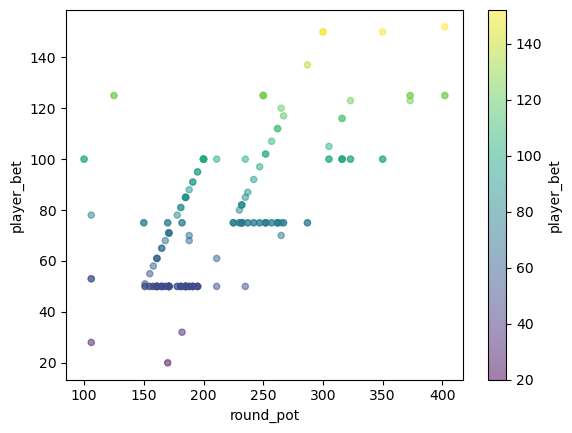

In [26]:
bet_df.plot.scatter(y='player_bet', x='round_pot', c='player_bet', colormap='viridis', alpha=0.5)

In [43]:
bet_df[['player_bet','round_pot','player_hand','house_visible_hand']].corr()

,player_bet,round_pot,player_hand,house_visible_hand
player_bet,1.000000,0.668430,0.164748,-0.249305
round_pot,0.668430,1.000000,0.120337,-0.223457
player_hand,0.164748,0.120337,1.000000,-0.044991
house_visible_hand,-0.249305,-0.223457,-0.044991,1.000000


Unfortunately, `round_pot` cannot be used for the regression. It is a leaky feature. There is a good correlation here though...

## Input modeling/representation

There are a couple of ways to model this:

1. Making a 'dummy'-variable on the cards of the player and representing that as a vector
2. Adding an additional vector for the visible house card and making it a negative sign
3. Using the player's hand as is
4. Adding the visible house hand as is

In [54]:
y = bet_df.player_bet
y.head()

0    120
1     70
2     75
3     70
4     50
Name: player_bet, dtype: int64

In [55]:
select_cols = ['player_cards','player_hand','card_1','card_2','house_visible_hand','house_card','player_bet']
bet_df['house_card'] = bet_df.house_visible_card.str.split().str[1]
bet_df[['card_1','card_2']] = bet_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",n=1,expand=True)
bet_df['card_1'] = bet_df['card_1'].str.split().str[1]
bet_df['card_2'] = bet_df['card_2'].str.split().str[1]
bet_df[select_cols].head()

,player_cards,player_hand,card_1,card_2,house_visible_hand,house_card,player_bet
0,"(Sp 9,Cl A)",20,9,A,11,A,120
1,"(Di 4,Sp Q)",14,4,Q,11,A,70
2,"(Di J,Hr 5)",15,J,5,11,A,75
3,"(Di 8,Hr K)",18,8,K,9,9,70
4,"(Cl K,Di 5)",15,K,5,9,9,50


In [71]:
player_input_df = pd.get_dummies(bet_df.card_1).astype(int)
player_input_df = player_input_df.add(pd.get_dummies(bet_df.card_2).astype(int), fill_value=0)
player_input_df = player_input_df[['2','3','4','5','6','7','8','9','10','J','Q','K','A']]
player_input_df.head()

,2,3,4,5,6,7,8,9,10,J,Q,K,A
0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,1,0


Below is just checking if the addition above worked correctly..

In [64]:
player_input_df.iloc[bet_df.loc[bet_df.card_1 == bet_df.card_2].index].head()

,10,2,3,4,5,6,7,8,9,A,J,K,Q
51,0,0,0,0,0,0,0,0,0,2,0,0,0
60,0,0,0,0,0,0,0,0,0,0,0,2,0
78,0,0,0,0,2,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,2,0,0,0
96,0,0,0,0,2,0,0,0,0,0,0,0,0


## Mathematical modeling

Here is the math behind linear regression:

$$
\begin{align}
Ax & = y \\
A^TAx & = A^Ty \\
(A^TA)^{-1}(A^TA)x  & = (A^TA)^{-1}A^Ty \\
x & = (A^TA)^{-1}A^Ty
\end{align}
$$

Another way to derive this equation is with the ***least square error*** derivation:

$$
\begin{align}
(Ax - y)^2 & = 0 \\
\therefore (Ax - y)^2\frac{\partial}{\partial x} = 2A^T(Ax - y)  & = 0 \\
A^TAx & = A^Ty \\
(A^TA)^{-1}(A^TA)x  & = (A^TA)^{-1}A^Ty \\
x & = (A^TA)^{-1}A^Ty
\end{align}
$$

Now, coding this with python, specifically using pytorch, looks like this:

In [83]:
A = tc.tensor(player_input_df.values, dtype=tc.int32)
A.shape
# tc.linalg.inv(A.t() * A)

torch.Size([181, 13])